## Subject Models

In [18]:
import pandas as pd
import json 


with open('index.txt', 'r') as index_file:
    rows = []
    for line in index_file:
        line = line.strip()
        model_name, metadata_string = line.split(' ', maxsplit=1)
        metadata = json.loads(metadata_string)
        rows.append(metadata)

df = pd.DataFrame(rows)

df.head()

,fn_name,parameter,loss,seed,weight_decay,epochs
0,multiplication,0.356396,1.151715e-04,726,0.1000,10000
1,min,0.659066,1.163055e-06,3856,0.0001,10000
2,exponent,0.632487,6.036503e-02,1076,1.0000,10000
3,exponent,0.293628,6.916875e-02,686,1.0000,10000
4,multiplication,0.072917,2.953429e-09,2061,0.0000,10000


In [21]:
df['fn_name'].value_counts()

fn_name
exponent          60291
addition          60030
sigmoid           60030
multiplication    59995
min               59450
Name: count, dtype: int64

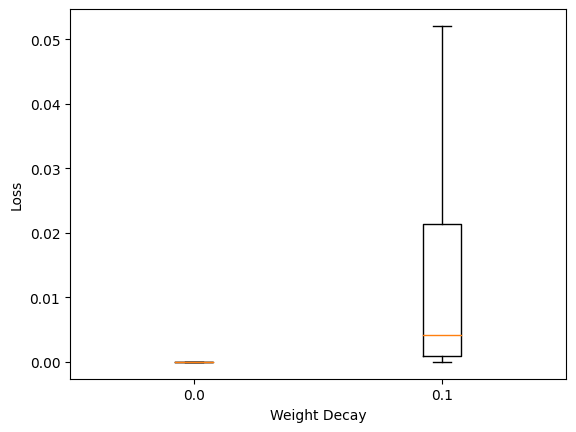

In [26]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Group the dataframe by 'Class'
grouped = df[df['weight_decay'].isin([0, 0.1])].groupby('weight_decay')

# Create a list of data for each class
data = [group['loss'].tolist() for name, group in grouped]

# Plot the boxplot
ax.boxplot(data, labels=grouped.groups.keys(), showfliers=False)

# Set x-axis and y-axis labels
ax.set_xlabel('Weight Decay')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

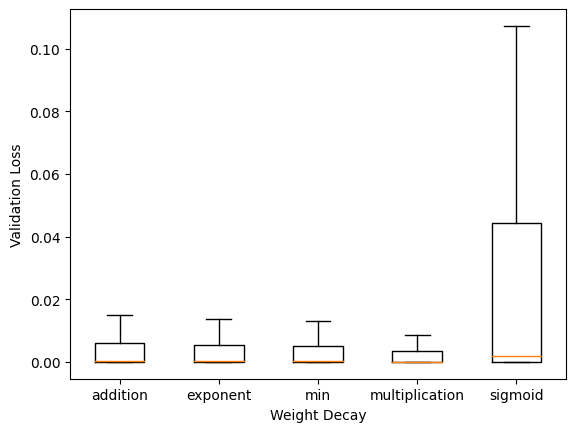

In [20]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Group the dataframe by 'Class'
grouped = df.groupby('fn_name')

# Create a list of data for each class
data = [group['loss'].tolist() for name, group in grouped]

# Plot the boxplot
ax.boxplot(data, labels=grouped.groups.keys(), showfliers=False)

# Set x-axis and y-axis labels
ax.set_xlabel('Weight Decay')
ax.set_ylabel('Validation Loss')

# Show the plot
plt.show()

In [13]:
import wandb
from train_subject_models import FUNCTION_NAMES
from datetime import datetime

api = wandb.Api()
runs = api.runs(
    path='patrickaaleask/bounding-mi',
    filters= {
        'config.functions': FUNCTION_NAMES,
        'State': 'finished',
        'created_at': {
            '$gt': "2023-06-26T00:00:00",
            '$lt': "2023-06-27T00:00:00",
        },
    },
)
print(f'Found {len(list(runs))} runs')

Found 60 runs


In [29]:
import pandas as pd
from scipy import stats

df = pd.DataFrame([(run.config['weight_decay'], run.summary['validation_loss']) for run in runs], columns=['Weight Decay', 'Validation Loss'])


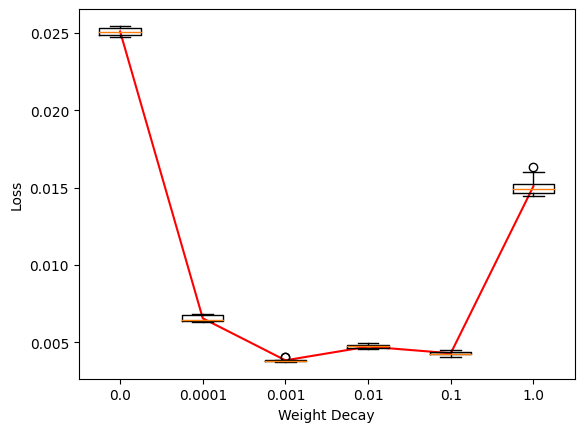

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a figure and axis object
fig, ax = plt.subplots()

# Group the dataframe by 'Class'
grouped = df.groupby('Weight Decay')

# Create a list of data for each class
data = [group['Validation Loss'].tolist() for name, group in grouped]

import numpy as np
means = [np.mean(d) for d in data]
plt.plot(range(1, len(data) + 1), means, marker='', color='red')

# Plot the boxplot
ax.boxplot(data, labels=grouped.groups.keys())

# Set x-axis and y-axis labels
ax.set_xlabel('Weight Decay')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

In [16]:
weight_decays = sorted(df['Weight Decay'].unique())

f_value, p_value = stats.f_oneway(*[df['Validation Loss'][df['Weight Decay'] == weight_decay] for weight_decay in weight_decays])

print(f'F-value: {f_value:.2f}')
print(f'p-value: {p_value}')

F-value: 7819.33
p-value: 6.647503941303006e-76


In [35]:
import torch


SUBJECT_MODEL_PARAMETER_COUNT = 726
class FeedForwardNN(nn.Module):
    def __init__(self, out_size):
        super().__init__()
        self.fc1 = nn.Linear(SUBJECT_MODEL_PARAMETER_COUNT, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, out_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        function_encoding = self.softmax(x[:, :-1])
        x = torch.cat([function_encoding, x[:, -1:]], dim=-1)
        return x

nn = FeedForwardNN(5)

sum(p.numel() for p in nn.parameters())

101637